# Time series forecasting with sktime
Estimated time: 40 min

## Introduction

What is a time series and what can we forecast?

![](../images/ts_quiz.png)

Factors that influence ”forecastability”:
1. How much data is available.
2. How similar the future is to the past.
3. How well we understand the factors that contribute to it.
4. Whether the forecasts can affect the thing we are trying to forecast.

## Agenda

- Quickstart
- Univariate forecasting
    - With statistical models
    - With machine learning models
    - Model evaluation and selection
- Univariate forecasting with exogenous data
- Multivariate forecasting
- Probabilistic forecasting
- Hierarchical forecasting

## Quickstart

* typical business use case :-)
* here's some monthly historic sales data

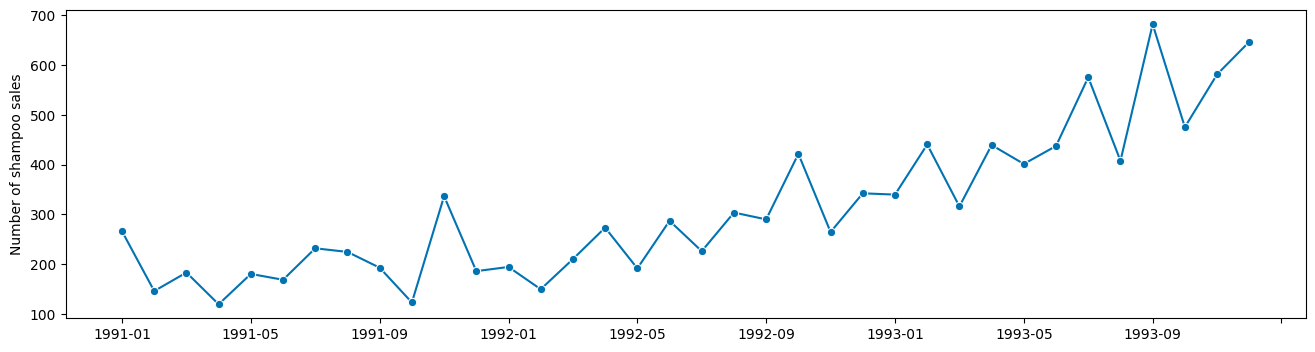

In [1]:
from sktime.datasets import load_shampoo_sales
from sktime.utils.plotting import plot_series

y = load_shampoo_sales()

fig, ax = plot_series(y)

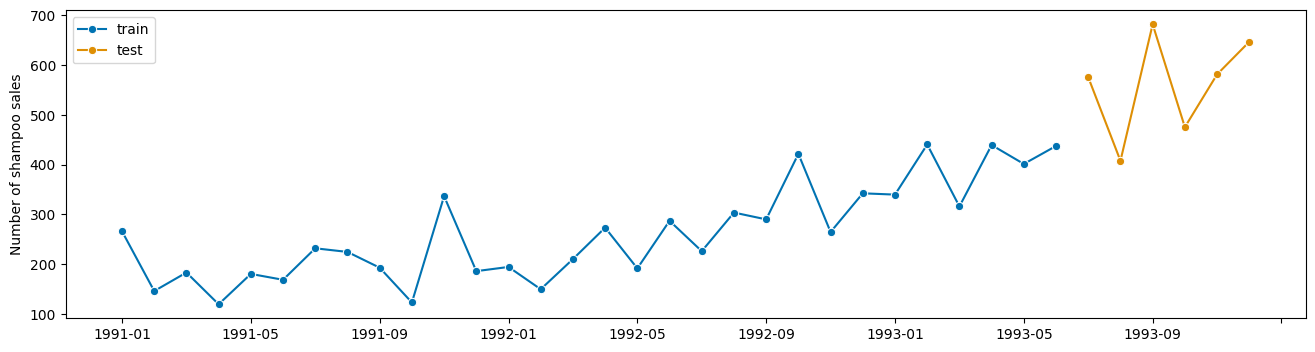

In [2]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y=y, test_size=6)
fig, ax = plot_series(y_train, y_test, labels=["train", "test"])

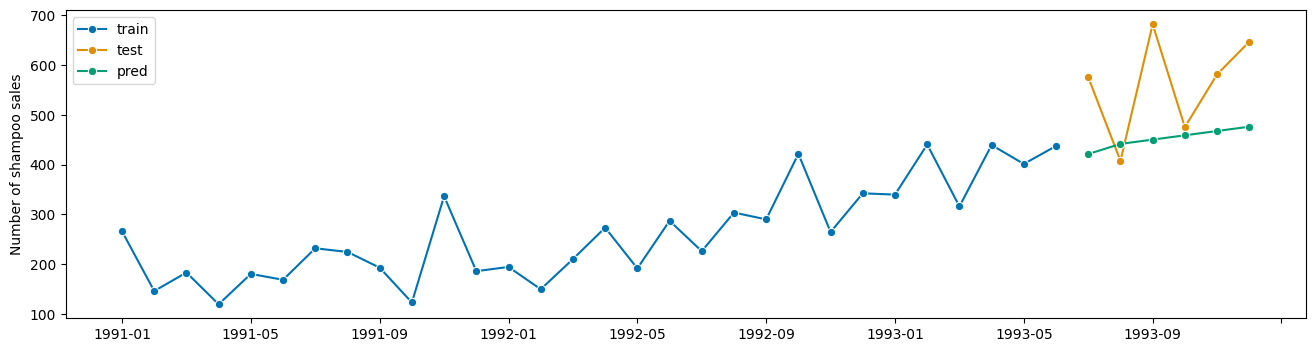

In [3]:
from sktime.forecasting.arima import AutoARIMA

# 1) Define the model
forecaster = AutoARIMA(suppress_warnings=True)

# 2) Fit on train data
forecaster.fit(y_train)

# 3) Use fitted model to predict for a certain forecast horizon (fh)
fh = [1, 2, 3, 4, 5, 6] # Relative to y_train
y_pred = forecaster.predict(fh)

fig, ax = plot_series(y_train, y_test, y_pred, labels=["train", "test", "pred"])

* scoring using `sktime` performance metrics
* requires forecasts & true values as `sktime` compatible time series

In [4]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric=True)

print(f"AutoARIMA - sMAPE error: {smape(y_test, y_pred):.1%}")

AutoARIMA - sMAPE error: 22.6%


Notes:

* MAPE just for illustration - not always best choice
* for robust evaluation & comparison, use backtesting (not single train/test split)

## Univariate forecasting

showcase common approaches for forecasting univariate time series in `sktime`:
- Classical statistical models (e.g., econometric, ARIMA, etc)
- Machine learning models (e.g., direct/recursive reduction)

Recommendation: try simple models and naive baselines first!

### Classical forecasting method example: `AutoETS`

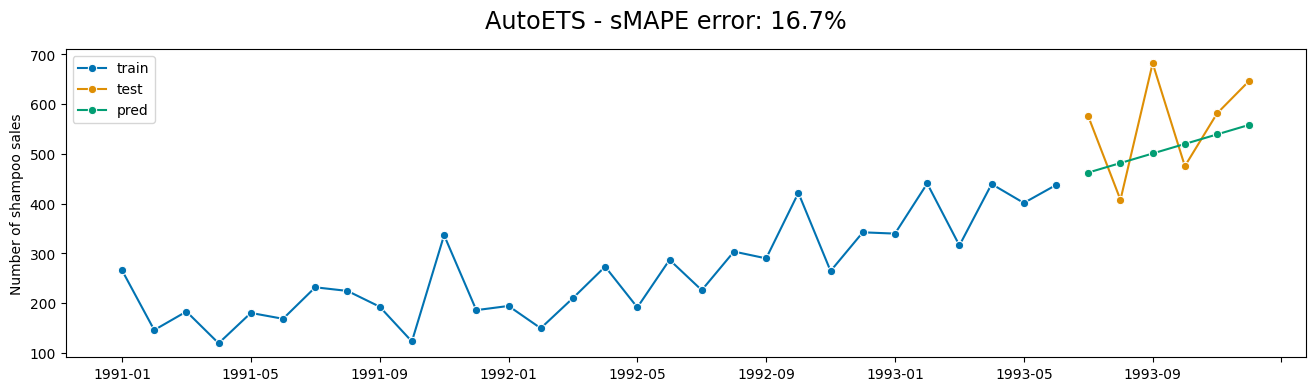

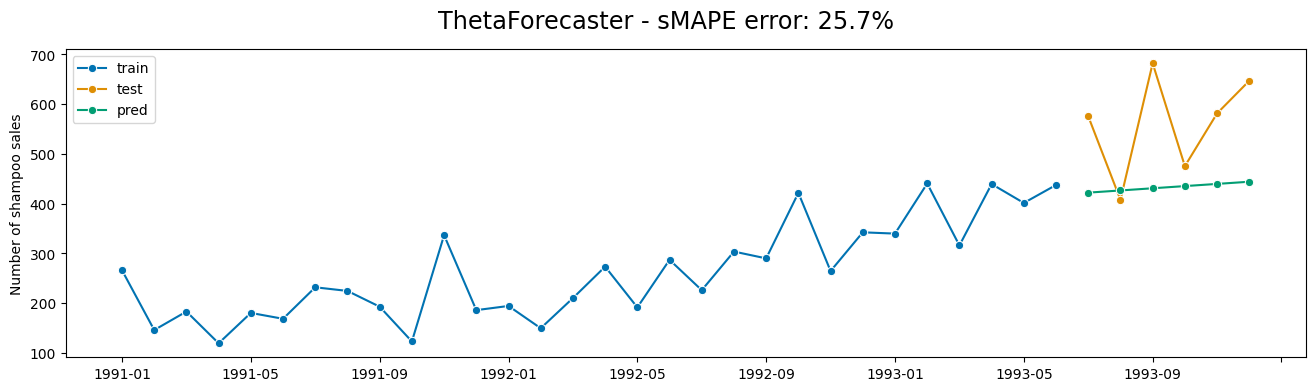

In [6]:
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.theta import ThetaForecaster

forecasters = [AutoETS(auto=True), ThetaForecaster()]

for forecaster in forecasters:
    y_pred = forecaster.fit_predict(y=y_train, fh=fh)
    title = (
        f"{str(forecaster).split('(')[0]} - sMAPE error: {smape(y_test, y_pred):.1%}"
    )
    fig, ax = plot_series(
        y_train, y_test, y_pred, labels=["train", "test", "pred"], title=title
    )

Check out all other sktime forecasting algorithms [in the documentation](https://www.sktime.net/en/latest/api_reference/forecasting.html) or by running the code below:

In [8]:
from sktime.registry import all_estimators

all_estimators("forecaster", as_dataframe=True, suppress_import_stdout=False)

,name,object
0,ARDL,<class 'sktime.forecasting.ardl.ARDL'>
1,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>
2,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>
3,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
4,AutoEnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.A...
5,BATS,<class 'sktime.forecasting.bats.BATS'>
6,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.Ba...
7,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
8,ConformalIntervals,<class 'sktime.forecasting.conformal.Conformal...
9,Croston,<class 'sktime.forecasting.croston.Croston'>


### Forecasting with ML algorithms (reduction)

- uses sklearn regressor on tabulated data to forecast
- plug & play any sklearn compatible regressor, e.g., lightgbm or xgboost
- important: forecasting != regression

Estimator does this internally:

![](../images/tabularization.png)

in unified forecasting interface! No need to handle `sklearn` directly

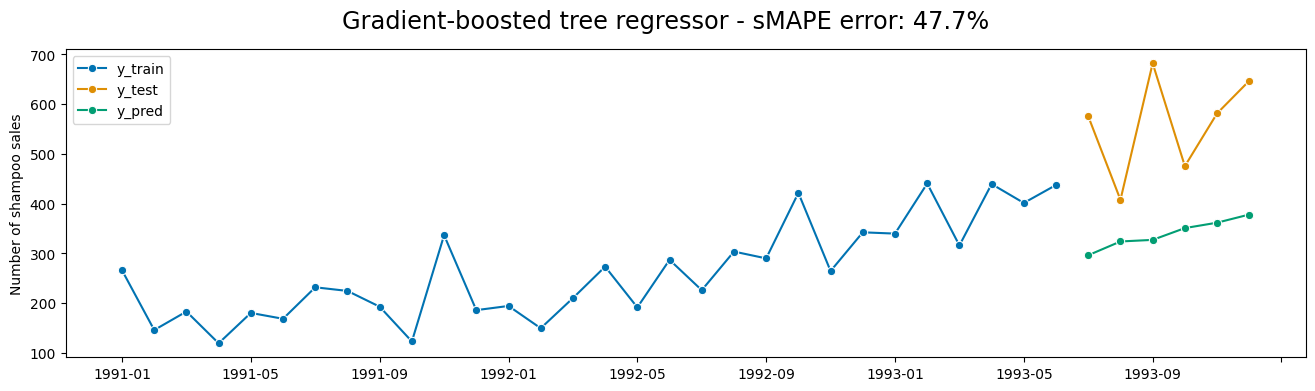

In [9]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sktime.forecasting.compose import make_reduction

# Can be swapped with XBGoost, LightGBM, CatBoost, etc.
regressor = HistGradientBoostingRegressor()

# Create a forecaster from the tabular regressor by wrapping it in `make_reduction`
forecaster = make_reduction(regressor, strategy="direct", window_length=16)

y_pred = forecaster.fit_predict(y=y_train, fh=fh)
title = f"Gradient-boosted tree regressor - sMAPE error: {smape(y_test, y_pred):.1%}"
fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title
)

... this is bad! Why?

Subtle:

- Gradient boosting trees cannot "extrapolate"
- only forecast well within their observed range

Solution: make (more) stationary by differencing

easy to do in `sktime`: transformers (= transformation estimators)

(note: wider concept than deep learn transformers, includes simple trafos too)

Let's see how to use the `Differencer` transformer:

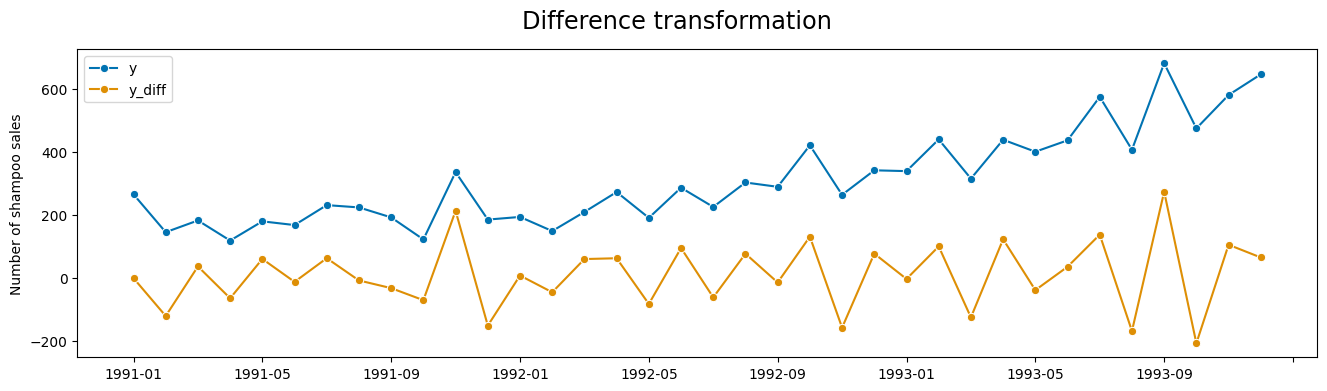

In [10]:
from sktime.transformations.series.difference import Differencer

transformer = Differencer(lags=1)
y_transform = transformer.fit_transform(y)
fig, ax = plot_series(
    y, y_transform, labels=["y", "y_diff"], title="Difference transformation"
)

Transformers composable with forecasters, plug together to forecaster!

here: plug `Differencer` into tree-based reduction forecaster, via `*` dunder:

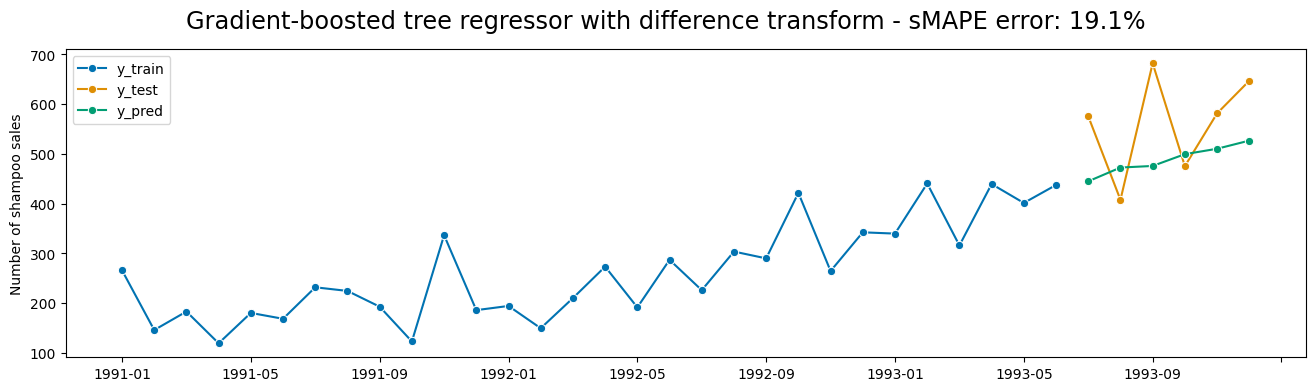

In [11]:
regressor = HistGradientBoostingRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=16)
forecaster_with_differencer = Differencer(lags=1) * forecaster

y_pred = forecaster_with_differencer.fit_predict(y=y_train, fh=fh)
title = f"Gradient-boosted tree regressor with difference transform - sMAPE error: {smape(y_test, y_pred):.1%}"
fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title
)

More on transformers and composition later!

### Model evaluation and selection

Best practice for model evaluation: backtesting, sliding window

(not single split MAPE etc...)

how this works:

* define backtesting schema using cross-validation splitter
* simple workflows: use `evaluate` all-in-one evaluator
* customizable: use benchmarking module for experiments

#### Window splitters

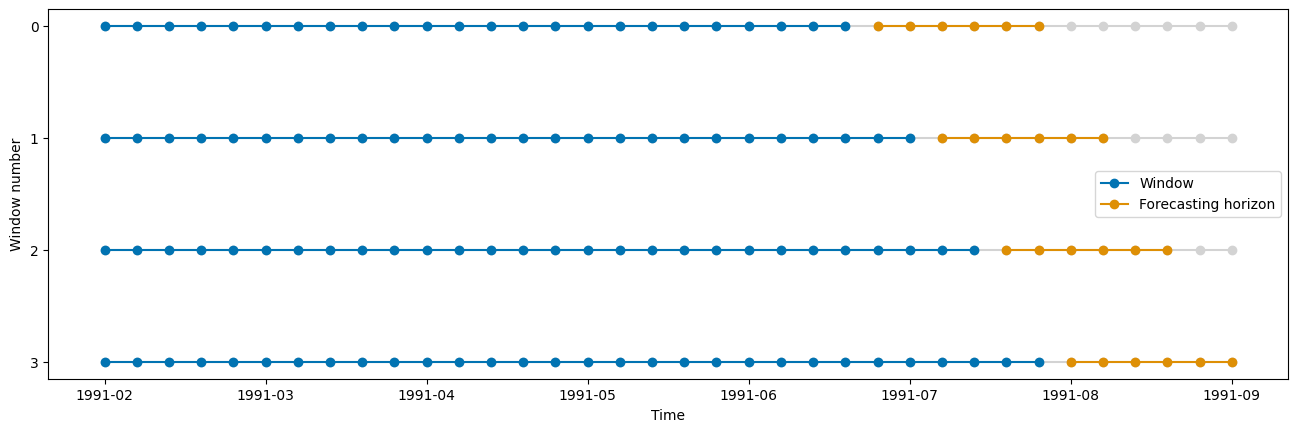

In [12]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.utils.plotting import plot_windows

cv = ExpandingWindowSplitter(initial_window=24, fh=fh, step_length=2)
n_folds = cv.get_n_splits(y)
plot_windows(cv, y)

#### Backtesting for single model evaluation

We can leverage this more rebust cross-validation strategies for sinlge model evaluation by using `sktime`'s evaluat function.

In [17]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanSquaredError

forecaster = forecaster_with_differencer.clone()
scorers = [smape, MeanSquaredError(square_root=True)]
backtest = evaluate(
    forecaster=forecaster, y=y, cv=cv, scoring=scorers, return_data=True
)
backtest

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred,test_MeanSquaredError
0,0.073314,0.333584,0.041451,24,1992-12,1991-01 266.0 1991-02 145.9 1991-03 1...,1993-01 339.7 1993-02 440.4 1993-03 3...,1993-01 326.533333 1993-02 363.933333 19...,38.216397
1,0.197408,0.234489,0.081608,26,1993-02,1991-01 266.0 1991-02 145.9 1991-03 1...,1993-03 315.9 1993-04 439.3 1993-05 4...,1993-03 443.72 1993-04 489.76 1993-05 ...,94.580702
2,0.157410,0.379060,0.111524,28,1993-04,1991-01 266.0 1991-02 145.9 1991-03 1...,1993-05 401.3 1993-06 437.4 1993-07 5...,1993-05 438.042857 1993-06 459.600000 19...,97.546607
3,0.190791,0.489880,0.064895,30,1993-06,1991-01 266.0 1991-02 145.9 1991-03 1...,1993-07 575.5 1993-08 407.6 1993-09 6...,1993-07 444.777778 1993-08 472.444444 19...,118.304354


In [19]:
backtest.loc[0, "y_pred"]

1993-01    326.533333
1993-02    363.933333
1993-03    364.900000
1993-04    430.100000
1993-05    417.066667
1993-06    434.533333
Freq: M, Name: Number of shampoo sales, dtype: float64

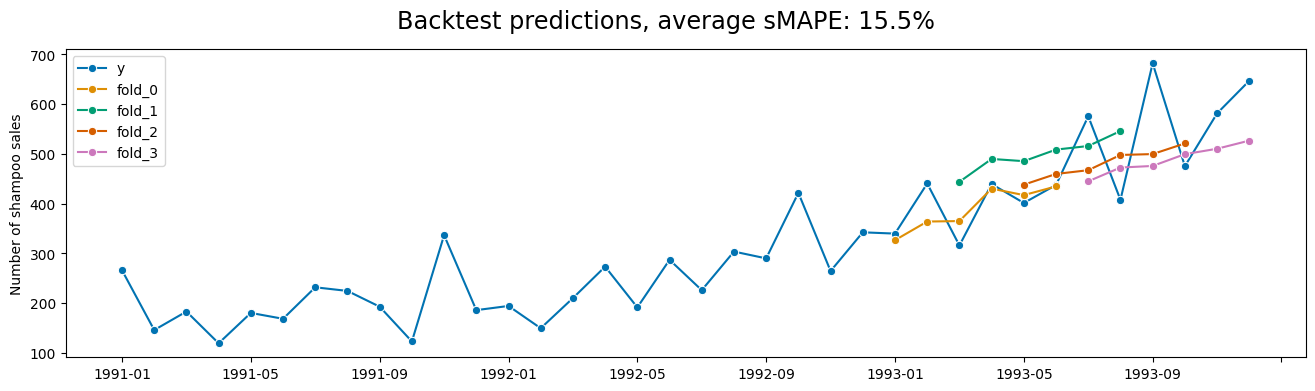

In [20]:
fig, ax = plot_series(
    y,
    *tuple(backtest["y_pred"][i] for i in range(n_folds)),
    labels=["y"] + [f"fold_{i}" for i in range(n_folds)],
    title=f"Backtest predictions, average sMAPE: {backtest['test_MeanAbsolutePercentageError'].mean():.1%}",
)

#### Advanced benchmarking via `ForecastingBenchmark`

* group of models in same benchmark scenario
* flexible set-up, e.g., splitters, evaluation metrics

Note: requires soft dependency [`kotsu`](https://github.com/datavaluepeople/kotsu) installed.

Start: create `ForecastingBenchmark` object

In [22]:
from sktime.benchmarking.forecasting import ForecastingBenchmark

benchmark = ForecastingBenchmark()

step 2: add models with `add_estimator` method.

Example: `NaiveForecaster` as simple benchmark model.

Good idea to assess baseline prediction accuracy!

In [23]:
from sktime.forecasting.naive import NaiveForecaster

benchmark.add_estimator(
    estimator=NaiveForecaster(strategy="mean", window_length=3),
    estimator_id="Naive-mean-3-v1",
)
benchmark.add_estimator(estimator=AutoARIMA(), estimator_id="AutoARIMA-v1")
benchmark.add_estimator(estimator=AutoETS(auto=True), estimator_id="AutoETS-v1")
benchmark.add_estimator(
    estimator=forecaster_with_differencer.clone(), estimator_id="LightGBM-v1"
)

Next - define backtest strategy `cv`, define forecasting tasks & scoring:

In [24]:
cv = ExpandingWindowSplitter(initial_window=24, fh=fh, step_length=2)
scorers = [smape]

benchmark.add_task(
    load_shampoo_sales,
    cv,
    scorers,
)

`run` to start benchmarking, this will now compute results:

In [26]:
results_df = benchmark.run(output_file="results.csv")
results_df.set_index("model_id").iloc[:, -2:].style.format("{:.1%}")

,MeanAbsolutePercentageError_mean,MeanAbsolutePercentageError_std
model_id,,
AutoARIMA-v1,18.4%,6.0%
AutoETS-v1,13.5%,3.3%
LightGBM-v1,15.5%,5.7%
Naive-mean-3-v1,20.3%,4.8%


Currently in active development! (summer programme)

- Open to feedback
- Welcome and appreciate contributions

## Univariate forecasting with exogenous data

- exogeneous data = other related time series that can improve prediction
- Example: information about promotions when forecasting sales (promotions drive sales)


We start by loading the same sales data we have been working on before.

In [27]:
from sktime.datasets import load_shampoo_sales

y = load_shampoo_sales()

Let's use the sales data, noise and some simple transformations to create *fake* promotion

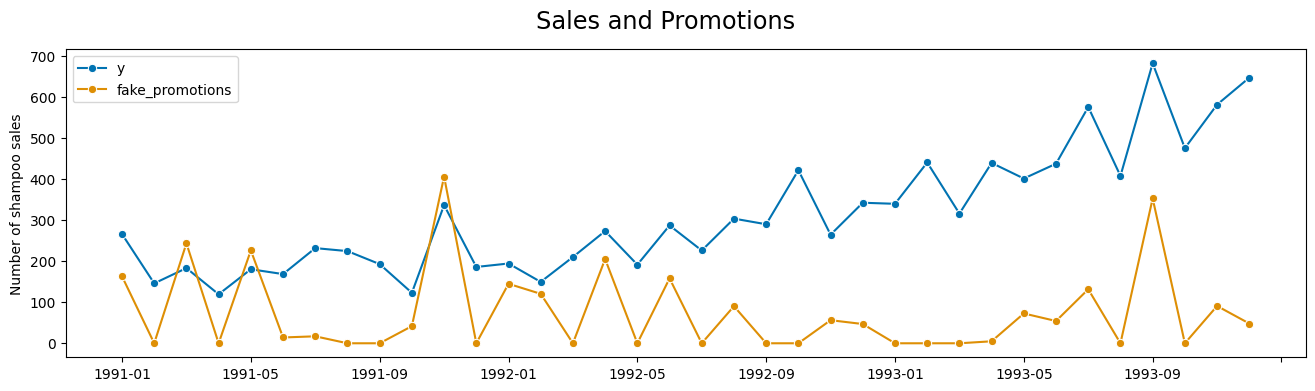

In [28]:
import numpy as np
from sktime.utils.plotting import plot_series
from sktime.transformations.series.difference import Differencer

# Use a differencer, clipping and some noise to generate fake promotional data
transformer = Differencer(lags=1)
y_transform = transformer.fit_transform(y)
noise = np.random.RandomState(seed=93).normal(0, 100, np.shape(y))
X_promo = (y_transform + noise).clip(lower=0)

fig, ax = plot_series(
    y, X_promo, labels=["y", "fake_promotions"], title="Sales and Promotions"
)

We can split both the target time series (y: sales) and the exogenous time series (X: promotions) with the `temporal_train_test_split` we have used before.

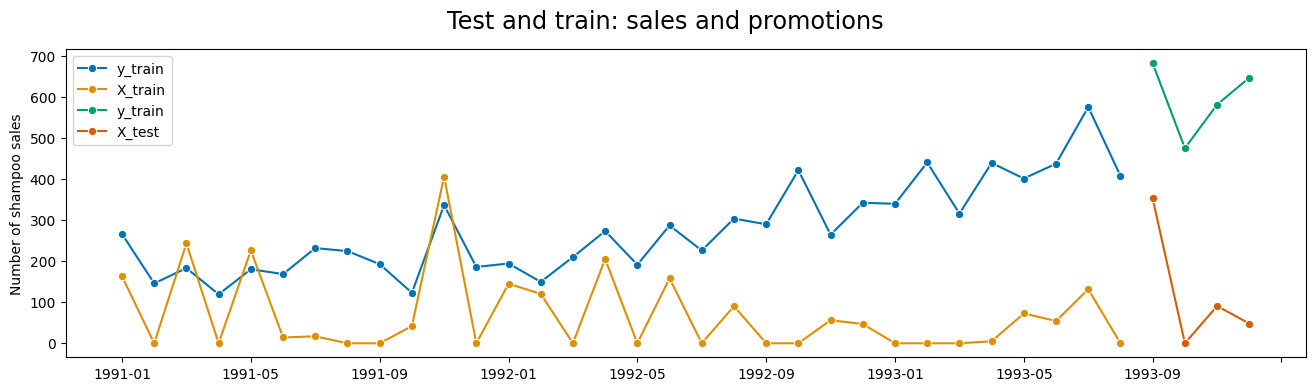

In [29]:
from sktime.forecasting.model_selection import temporal_train_test_split

fh = [1, 2, 3, 4]
y_train, y_test, X_train, X_test = temporal_train_test_split(
    y=y, X=X_promo, test_size=len(fh)
)

fig, ax = plot_series(
    y_train,
    X_train,
    y_test,
    X_test,
    labels=["y_train", "X_train", "y_train", "X_test"],
    title="Test and train: sales and promotions",
)

Now we can forecast y (sales) also using the known values of future X (promotions) by passing the future X data in the predict step.

In [30]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(suppress_warnings=True)

# Use train data in fit
forecaster.fit(y=y_train, X=X_train, fh=fh)

# Note how the "future" data of X is passed in the predict step
y_pred = forecaster.predict(X=X_test)

Let's see how the prediction looks like when adding promotional data.

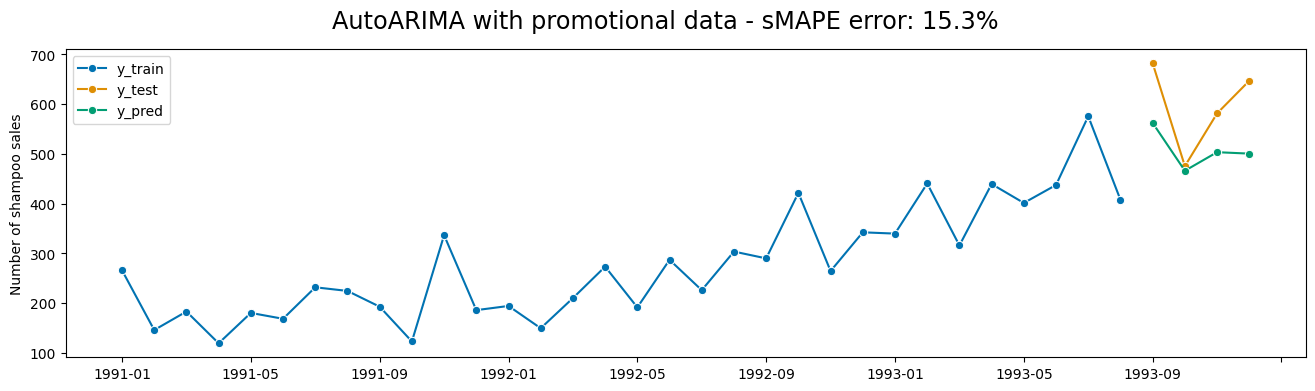

In [31]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric=True)

title = f"AutoARIMA with promotional data - sMAPE error: {smape(y_test, y_pred):.1%}"
fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title
)

Note: as we created the promotions from the sales data, the performance upflift is over-optimistic (data leakage).

But what if don't have future promotional data?

If we believe that we can forecast `X` (promotions) independently of `y` (sales) we can use these predictions of `X` to inform the predictions of `y`.

Here, we decide to use a different model for `X` than for `y`:
- y (sales): AutoARIMA
- X (promotion): Croston - due to intermittency


In [32]:
from sktime.forecasting.compose import ForecastX
from sktime.forecasting.croston import Croston

forecaster_X = ForecastX(
    forecaster_y=AutoARIMA(suppress_warnings=True),
    forecaster_X=Croston(),
)
forecaster_X.fit(y=y, X=X_promo, fh=fh)

ForecastX(forecaster_X=Croston(),
          forecaster_y=AutoARIMA(suppress_warnings=True))

After fitting on both `X` and `y` we can creat predictions of `y` directly. Under the hood `sktime` is forecasting `X` with the `Croston()` model and using it in the prediction step of `y`.

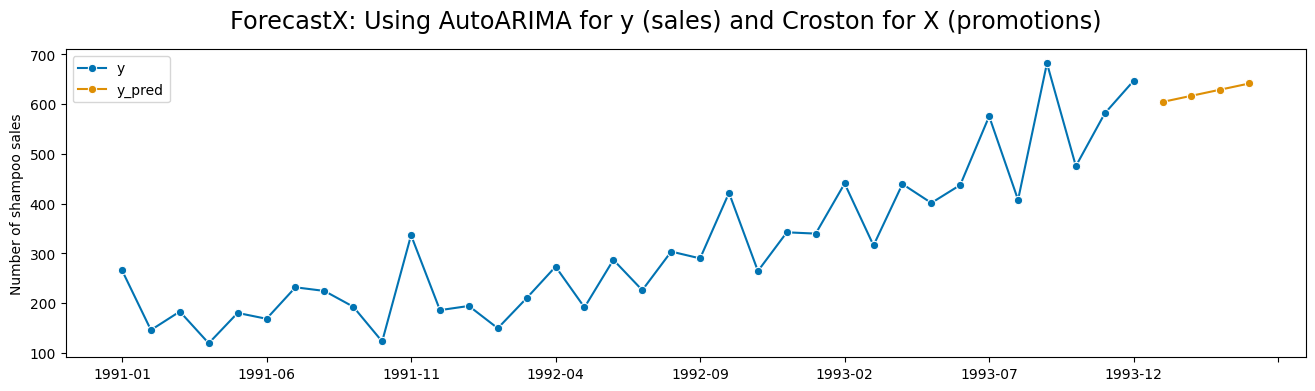

In [33]:
# Now in the `predict` step we don't need to pass X
y_pred = forecaster_X.predict(fh=fh)

title = f"ForecastX: Using AutoARIMA for y (sales) and Croston for X (promotions)"
fig, ax = plot_series(
    y, y_pred, labels=["y", "y_pred"], title=title
)

- Sometimes, the focus is not on a single univariate time series, but rather on forecasting a group of time series that represent different aspects of a single entity.
- Example: forecasting multiple macroeconomic indicators that collectively measure "the economy".

Let's explore how `sktime` enables multivariate forecasting for this use-case.

## Multivariate

We begin by loading the historical data of a couple of macro indicators, which are reported yearly.

In [34]:
from sktime.datasets import load_longley

_, y = load_longley()

y = y.drop(columns=["UNEMP", "ARMED", "POP"])

y

,GNPDEFL,GNP
Period,,
1947,83.0,234289.0
1948,88.5,259426.0
1949,88.2,258054.0
1950,89.5,284599.0
1951,96.2,328975.0
1952,98.1,346999.0
1953,99.0,365385.0
1954,100.0,363112.0
1955,101.2,397469.0


In `sktime` some forecasters such as `VAR()` are purely mutlivariate. Let's use it to make some predictions:

In [35]:
from sktime.forecasting.var import VAR

forecaster = VAR()
forecaster.fit(y, fh=[1, 2, 3])

y_pred = forecaster.predict()
y_pred

,GNPDEFL,GNP
Period,,
1963,121.688295,578514.398653
1964,124.353664,601873.015890
1965,126.847886,625411.588754


We can inspects the tags of the `VAR()` forecasteer through to `get_tags` to check its multivariate nature.

In [36]:
forecaster.get_tags()

{'scitype:y': 'multivariate',
 'ignores-exogeneous-X': True,
 'capability:insample': True,
 'capability:pred_int': True,
 'capability:pred_int:insample': False,
 'handles-missing-data': False,
 'y_inner_mtype': 'pd.DataFrame',
 'X_inner_mtype': 'pd.DataFrame',
 'requires-fh-in-fit': False,
 'X-y-must-have-same-index': True,
 'enforce_index_type': None,
 'fit_is_empty': False,
 'python_version': None,
 'python_dependencies': 'statsmodels',
 'univariate-only': False}

But we can also use univariate forecasters to forecast multiple time series! Let's see how this is done using `ARIMA` which is a purely univariate model.

In [37]:
from sktime.datasets import load_longley
from sktime.forecasting.arima import ARIMA

_, y = load_longley()

y = y.drop(columns=["UNEMP", "ARMED", "POP"])

forecaster = ARIMA()
forecaster.fit(y, fh=[1, 2, 3])

forecaster.forecasters_

1,GNP,GNPDEFL
0,,
forecasters,ARIMA(),ARIMA()


As we can see `sktime` fits one single `ARIMA()` model per time series.

We can also check the nature of the `ARIMA()` model using the `get_tags`.

In [38]:
forecaster.get_tags()

{'scitype:y': 'univariate',
 'ignores-exogeneous-X': False,
 'capability:insample': True,
 'capability:pred_int': True,
 'capability:pred_int:insample': True,
 'handles-missing-data': True,
 'y_inner_mtype': 'pd.Series',
 'X_inner_mtype': 'pd.DataFrame',
 'requires-fh-in-fit': False,
 'X-y-must-have-same-index': True,
 'enforce_index_type': None,
 'fit_is_empty': False,
 'python_version': None,
 'python_dependencies': 'pmdarima'}

- Point predictions may not suffice in many forecasting scenarios.
- Even with the best models, forecasts inherently contain some level of uncertainty.
- This uncertainty can be expressed, by for example, providing prediction intervals.

`sktime` allows for straightforward generation of prediction intervals to capture forecast uncertainty.

## Probabilistic forecasting

In [39]:
from sktime.datasets import load_shampoo_sales

y = load_shampoo_sales()

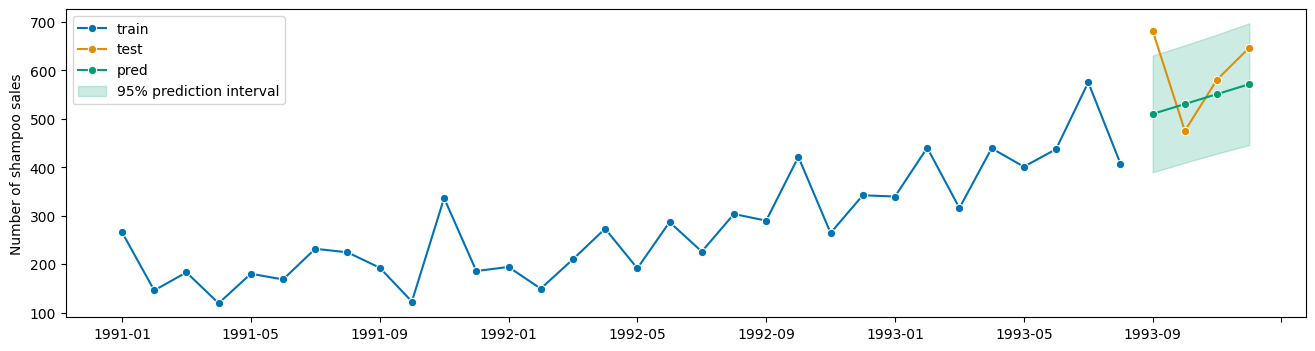

In [40]:
from sktime.forecasting.ets import AutoETS

# 1) Define the model
forecaster = AutoETS(auto=True)

# 2) Fit on train data
forecaster.fit(y_train)

# 3) Use fitted model to predict for a certain forecast horizon (fh)
fh = [1, 2, 3, 4]
y_pred = forecaster.predict(fh)

# 4) Call a probabilistic method after or in place of step 3
y_pred_int = forecaster.predict_interval(coverage=0.95)

fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["train", "test", "pred"], pred_interval=y_pred_int
)

The following methods are possibly available for probabilistic forecasts:

- `predict_interval` produces interval forecasts. Additionally to any `predict` arguments, an argument `coverage` (nominal interval coverage) must be provided.
- `predict_quantiles` produces quantile forecasts. Additionally to any `predict` arguments, an argument `alpha` (quantile values) must be provided.
- `predict_var` produces variance forecasts. This has same arguments as `predict`.
- `predict_proba` produces full distributional forecasts. This has same arguments as `predict`.

| Name | param | prediction/estimate of | `sktime` |
| ---- | ----- | ---------------------- | -------- |
| point forecast | | conditional expectation $\mathbb{E}[y'\|y]$ | `predict` |
| variance forecast | | conditional variance $Var[y'\|y]$ | `predict_var` |
| quantile forecast | $\alpha\in (0,1)$ | $\alpha$-quantile of $y'\|y$ | `predict_quantiles` |
| interval forecast | $c\in (0,1)$| $[a,b]$ s.t. $P(a\le y' \le b\| y) = c$ | `predict_interval` |
| distribution forecast | | the law/distribution of $y'\|y$ | `predict_proba` |

We can check which estimators can perform probabiilistic forecasting by checking `all_stimators`.

In [41]:
from sktime.registry import all_estimators

all_estimators(
    "forecaster",
    filter_tags={"capability:pred_int": True},
    as_dataframe=True,
    suppress_import_stdout=False,
)

,name,object
0,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>
1,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>
2,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
3,BATS,<class 'sktime.forecasting.bats.BATS'>
4,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.Ba...
5,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
6,ConformalIntervals,<class 'sktime.forecasting.conformal.Conformal...
7,DynamicFactor,<class 'sktime.forecasting.dynamic_factor.Dyna...
8,ForecastX,<class 'sktime.forecasting.compose._pipeline.F...
9,ForecastingGridSearchCV,<class 'sktime.forecasting.model_selection._tu...


Note:  estimators that have the `pred_int` tag always have all the probabilistic methods available. So estimators either have all of them or none.

Now let's look at the difference probabilistic methods and their different outputs.

In [42]:
forecaster.predict_interval(coverage=0.95)

Coverage            
               0.95            
              lower       upper
1993-09  389.650332  630.743227
1993-10  409.429946  651.972676
1993-11  428.319101  674.092585
1993-12  446.003141  697.417607

In [43]:
forecaster.predict_quantiles(alpha=[0.275, 0.95])

Quantiles            
              0.275       0.950
1993-09  473.431890  611.362548
1993-10  493.715332  632.475449
1993-11  513.727198  654.335648
1993-12  533.371521  677.207210

In [44]:
forecaster.predict_var()

,0
1993-09,3782.793645
1993-10,3828.426831
1993-11,3931.098079
1993-12,4113.621699


To predict full predictive distributions, `predict_proba` can be used. This returns a `BaseDistribution` child instance.

In [45]:
forecaster.predict_proba()

Normal(columns=Index(['Number of shampoo sales'], dtype='object'),
       index=PeriodIndex(['1993-09', '1993-10', '1993-11', '1993-12'], dtype='period[M]'),
       mu=         Number of shampoo sales
1993-09               510.196780
1993-10               530.701311
1993-11               551.205843
1993-12               571.710374,
       sigma=                 0
1993-09  61.504420
1993-10  61.874282
1993-11  62.698470
1993-12  64.137522)

## Hierarchical forecasting

![](../images/hierarchy.png)

Let's use some sktime utilities to create a hierarchical dataframe of historical monthly sales

In [46]:
from odsc_utils import load_product_hierarchy

y = load_product_hierarchy()

y

Sales
Product line      Product group Date          
Food preparation  Hobs          2000-01  245.0
                                2000-02  144.0
                                2000-03  184.0
                                2000-04  265.0
                                2000-05  236.0
...                                        ...
Food preservation Fridges       2004-08  176.0
                                2004-09  205.0
                                2004-10   59.0
                                2004-11  151.0
                                2004-12  173.0

[240 rows x 1 columns]

We can pick a specific date to clearly see the hierarchy.

In [47]:
# Multiindex slicing can become important when using hierarchical data!
y.loc[(slice(None), slice(None), "2000-01")]

Sales
Product line      Product group       
Food preparation  Hobs           245.0
                  Ovens          114.0
Food preservation Freezers       164.0
                  Fridges        136.0

Now we can visualize the different time series in the hierarchy

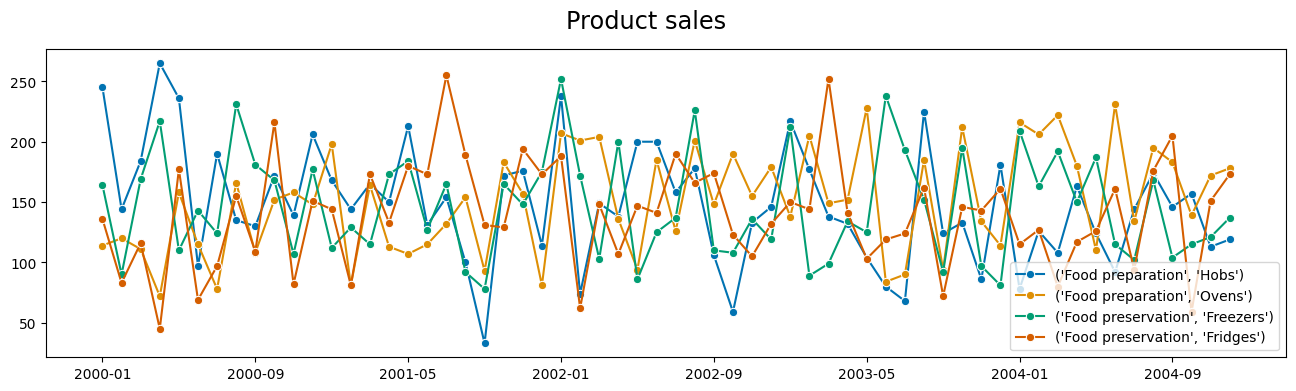

In [48]:
product_index = y.droplevel(-1).index.unique()
fig, ax = plot_series(*(y.loc[idx] for idx in product_index), labels=product_index, title="Product sales")

Forecasting this data simultaneously is easy as `sktime` automatically vectorizes/"up-casts" the models to hierarchical data.

In [49]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True)

y_pred = forecaster.fit_predict(y, fh=[1])
y_pred

Sales
Product line      Product group Date               
Food preparation  Hobs          2005-01  119.460074
                  Ovens         2005-01  169.749302
Food preservation Freezers      2005-01  146.466768
                  Fridges       2005-01  139.583350

In [50]:
forecaster.forecasters_

1                                  forecasters
Food preparation  Hobs      AutoETS(auto=True)
                  Ovens     AutoETS(auto=True)
Food preservation Freezers  AutoETS(auto=True)
                  Fridges   AutoETS(auto=True)

When working with hierarchies we often want to provide forecasts of the aggregated levels too.

Right now for this we would manually sum up the predictions for the lower levels that we are interested in.

A better way to do this is by using the `Aggregator` transformer in `sktime`.

In [51]:
from sktime.transformations.hierarchical.aggregate import Aggregator

y_hier = Aggregator().fit_transform(y)

y_hier.loc[(slice(None), slice(None), "2000-01")]

Sales
Product line      Product group       
Food preparation  Hobs           245.0
                  Ovens          114.0
                  __total        359.0
Food preservation Freezers       164.0
                  Fridges        136.0
                  __total        300.0
__total           __total        659.0

In [52]:
forecaster = AutoETS(auto=True, random_state=0)

y_hier_pred = forecaster.fit_predict(y_hier, fh=1)
y_hier_pred

Sales
Product line      Product group Date               
Food preparation  Hobs          2005-01  119.460074
                  Ovens         2005-01  169.749302
                  __total       2005-01  298.431264
Food preservation Freezers      2005-01  146.466768
                  Fridges       2005-01  139.583350
                  __total       2005-01  286.049278
__total           __total       2005-01  584.481426

If we compare the predictions at the top level with the sum of the bottom level forecast we can check that they are not the same!

In [53]:
584.481241 - (119.460419 + 169.749332 + 146.466778 + 139.583316)

9.221396000000027

This is because independent instances of each forecaster are fitted per level and there is currently no constrain to ensure the predictions add up.

In [54]:
forecaster.forecasters_

1                                                  forecasters
Food preparation  Hobs      AutoETS(auto=True, random_state=0)
                  Ovens     AutoETS(auto=True, random_state=0)
                  __total   AutoETS(auto=True, random_state=0)
Food preservation Freezers  AutoETS(auto=True, random_state=0)
                  Fridges   AutoETS(auto=True, random_state=0)
                  __total   AutoETS(auto=True, random_state=0)
__total           __total   AutoETS(auto=True, random_state=0)

We can use `ReconcilerForecaster` enfore hierarchical reconciliation to solve this problem.

The `ReconcilerForecaster` takes in a forecaster and add a reconciliation method.

In [55]:
from sktime.forecasting.reconcile import ReconcilerForecaster

reconciler_forecaster = ReconcilerForecaster(
    forecaster=forecaster.clone(), method="bu"
)

y_hier_pred = reconciler_forecaster.fit_predict(y_hier, fh=1)
y_hier_pred

Sales
Product line      Product group Date               
Food preparation  Hobs          2005-01  119.460074
                  Ovens         2005-01  169.749302
                  __total       2005-01  289.209375
Food preservation Freezers      2005-01  146.466768
                  Fridges       2005-01  139.583350
                  __total       2005-01  286.050118
__total           __total       2005-01  575.259493

Now the top level and sum of the bottom level are the same.

In [56]:
575.259845 - (119.460419 + 169.749332 + 146.466778 + 139.583316)

1.1368683772161603e-13

We can retirieve the available reconciliation methods easily.

In [57]:
print("Valid reconciliation methods:")
for method in ReconcilerForecaster.METHOD_LIST:
    print(f"- {method}")

Valid reconciliation methods:
- mint_cov
- mint_shrink
- wls_var
- bu
- ols
- wls_str
- td_fcst


We can also define different forecasters at different hierarchy levels (or hierarchy nodes) by using the `HierarchyEnsembleForecaster`. 

Forecasters built this way also aggregate the hierachical data for you under the hood.

In [58]:
from odsc_utils import load_product_hierarchy

y = load_product_hierarchy()

In [59]:
from sktime.forecasting.compose import HierarchyEnsembleForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS

forecasters = [
    ('Auto ARIMA', AutoARIMA(), 0),
    ('Auto ETS', AutoETS(auto=True), 1)
]

forecaster = HierarchyEnsembleForecaster(
                forecasters=forecasters,
                by='level', default = AutoETS(auto=True)
)

y_pred = forecaster.fit_predict(y, fh=[1])

y_pred

Sales
Product line      Product group Date               
Food preparation  Hobs          2005-01  119.460074
                  Ovens         2005-01  169.749302
                  __total       2005-01  298.431264
Food preservation Freezers      2005-01  146.466768
                  Fridges       2005-01  139.583350
                  __total       2005-01  286.049278
__total           __total       2005-01  585.824586

Up to now, we have been always forecasting the hierachical data locally, but we can also leverage global forecasting:
- Local: fit a model to each time series locally
- Global: fit a single model to all the series

### Global forecasting

Benefits of global forecasting:
- The model has access to more data to learn from, great when individual time series are short.
- Faster than local approach
- Empirically shown to outperform local models (e.g. M5 forecasting competition)

Note: global models assume the data generating procress for the group of time series is the same or at least similar.

In [60]:
from odsc_utils import load_product_hierarchy
from sktime.forecasting.model_selection import temporal_train_test_split

y = load_product_hierarchy()

y_train, y_test = temporal_train_test_split(y_hier, test_size=4)

y_test

Sales
Product line      Product group Date          
Food preparation  Hobs          2004-09  146.0
                                2004-10  157.0
                                2004-11  113.0
                                2004-12  119.0
                  Ovens         2004-09  183.0
                                2004-10  139.0
                                2004-11  172.0
                                2004-12  178.0
                  __total       2004-09  329.0
                                2004-10  296.0
                                2004-11  285.0
                                2004-12  297.0
Food preservation Freezers      2004-09  104.0
                                2004-10  115.0
                                2004-11  121.0
                                2004-12  137.0
                  Fridges       2004-09  205.0
                                2004-10   59.0
                                2004-11  151.0
                                2004-12  173.0
                  __total       2004-09  309.0
                                2004-10  174.0
                                2004-11  272.0
                                2004-12  310.0
__total           __total       2004-09  638.0
                                2004-10  470.0
                                2004-11  557.0
                                2004-12  607.0

Let's begin by using local forecasting with the gradient boosting regressor we used previously to forecast the hierarchical data.

In [61]:
regressor = HistGradientBoostingRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=12, pooling="local")

y_pred = forecaster.fit_predict(y_train, fh=[1, 2, 3, 4])

In [62]:
forecaster.forecasters_

1                                                                 forecasters
Food preparation  Hobs      DirectTabularRegressionForecaster(estimator=Hi...
                  Ovens     DirectTabularRegressionForecaster(estimator=Hi...
                  __total   DirectTabularRegressionForecaster(estimator=Hi...
Food preservation Freezers  DirectTabularRegressionForecaster(estimator=Hi...
                  Fridges   DirectTabularRegressionForecaster(estimator=Hi...
                  __total   DirectTabularRegressionForecaster(estimator=Hi...
__total           __total   DirectTabularRegressionForecaster(estimator=Hi...

We can adapt the error metrics to a hierarchical setting by using `multilevel` argument to obtain scores for each level.

In [63]:
hier_smape = MeanAbsolutePercentageError(symmetric=True, multilevel="raw_values")
errors_local = hier_smape(y_test, y_pred)
errors_local

1                           MeanAbsolutePercentageError
Food preparation  Hobs                         0.134782
                  Ovens                        0.175641
                  __total                      0.076075
Food preservation Freezers                     0.307519
                  Fridges                      0.482346
                  __total                      0.135877
__total           __total                      0.144789

Now with the same regressor, we do global forecasting by setting the `pooling` argument to `global`.

In [64]:
regressor = HistGradientBoostingRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=12, pooling="global")

y_pred = forecaster.fit_predict(y_train, fh=[1, 2, 3, 4])

Let's compare the scores for the `local` and `global` approach.

In [65]:
errors_global = hier_smape(y_test, y_pred)

print(f"Average sMAPE with local pooling: {errors_local.mean().iloc[0]:.1%}")
print(f"Average sMAPE with global pooling: {errors_global.mean().iloc[0]:.1%}")

Average sMAPE with local pooling: 20.8%
Average sMAPE with global pooling: 19.4%


Quick recap of what we have covered in this notebook:

- Univariate forecasting (stats and ML)
- Univariate with exogenous data
- Multivariate forecasting
- Probabilistic forecasting
- Hierarchical forecasting

### Credits: notebook 3 - forecasting

notebook creation: marrov, fkiraly

partly based on:

* pydata 2022 Berlin notebooks (fkiraly, danbartl)
* sktime forecasting tutorial (fkiraly, mloning and others)

sktime forecasting module: [many contributors](https://www.sktime.net/en/latest/about/contributors.html)